# Planetary Nebula <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# some basic packages
import os                 # filesystem related stuff
from pathlib import Path  # use instead of os.path and glob
import sys                # mostly replaced by pathlib

import errno      # more detailed error messages
import warnings   # handles warnings
import logging    # use logging instead of print

from collections import OrderedDict  

# packages for scientific computing
import numpy as np
import scipy as sp

# packages for creating plots and figures
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# special functions for astronomy 
from astropy.table import Table  # useful datastructure
from astropy.table import vstack # combine multiple tables

from astropy.io import fits      # open fits files
from astropy.io import ascii     # handle normal files

from astropy.wcs import WCS               # handle coordinates
from astropy.coordinates import SkyCoord  # convert pixel to sky coordinates

from astropy.stats import sigma_clipped_stats  # calcualte statistics of images

import astropy.units as u        # handle units

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

### Reference files

To test the newly written routines we compare our results to those from Kreckel et al. (2017)

**Requires** (both already loaded with standard packages)
 * `astropy.io.ascii`
 * `astropy.coordinates.SkyCoord`
 
**Returns**
 * `pn_kreckel` table with all PNe detected by Kreckel et al. (2017)
 * `pn_bright` only PNe that are brighter than the completeness limit
 * `pn_hermann` only PNe that were also detected by Hermann et al. 2008

In [3]:
pn_kreckel = ascii.read(os.path.join('..','data','external','kreckel_pn_2017.txt'))

def string_to_ra(string):
    '''convert coordinates from Kreckel et al. (2017) to astropy
    
    the right ascension in the paper is given as 
    "01:36:42.212" but astropy requires "01h36m42.212s".
    This function replaces the ":" with the appropriate character.
    '''
    return string.replace(':','h',1).replace(':','m') + 's'

def string_to_dec(string):
    '''convert coordinates from Kreckel et al. (2017) to astropy
    
    the declination in the paper is given as "01:36:42.212" 
    but astropy requires "01d36m42.212s".
    This function replaces the ":" with the appropriate character.
    '''
    return string.replace(':','d',1).replace(':','m') + 's'

# convert string to astronomical coordinates
pn_kreckel['RA'] = list(map(string_to_ra,pn_kreckel['RA']))
pn_kreckel['DEC'] = list(map(string_to_dec,pn_kreckel['DEC']))
pn_kreckel['SkyCoord'] = SkyCoord(pn_kreckel['RA'],pn_kreckel['DEC'])

# select some subsets (PN from Hermann et al. 2008 or bright sources only)
pn_herrmann = pn_kreckel[[True if i.endswith('a') else False for i in pn_kreckel['ID']]]
pn_bright = pn_kreckel[pn_kreckel['mOIII']<27]

### Read in data

this uses the `ReadLineMaps` class from the `pymuse.io` module. To use it, we first need to specify the path to the data folder

In [7]:
from pymuse.io import ReadLineMaps

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
basedir = Path('..')

# list all files in the specified directory
galaxies = [x.name for x in data_raw.iterdir() if x.is_dir()]
#print(', '.join(map(str,galaxies)))

# read in the data we will be working with and print some information
NGC628 = ReadLineMaps(data_raw / 'NGC628')
print(NGC628)

INFO:pymuse.io:loading NGC628
INFO:pymuse.io:replacing OIII5006 map
INFO:pymuse.io:file loaded with 4 extensions
name: NGC628
filename
lines
header
wcs
shape
whitelight
OIII5006
OIII5006_err
HA6562
HA6562_err
NII6583
NII6583_err
SII6716
SII6716_err
OIII5006_DAP
OIII5006_DAP_err
PSF



## Source Detection

There are two different approaches to identifying sources in an image. The first utilizes PSF fitting and uses implementations from astropy. The other uses the external `SExtractor` package which detects peaks and classifies them with a neural network.

### Based on IRAFStarFinder or DAPStarFinder

The sources we are searching for are unresolved. However due to seeing, they will be smeared out. This PSF has the form of a Gaussian (or Moffat). The subsequent algorithms use this and try to fit a theoretical curve to the observed peaks in the image. If the fit aggrees within some threshold, it reports the peak as a source. The advantage is that for crowded fields, the algorithm will try to fit an individual function to each peak and thus enable us correctly identfiy objects that are closeby.

The following function is based on this tutorial 

https://photutils.readthedocs.io/en/stable/detection.html

https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder

**Requires**
 * A `photutils` starfinder. This can be either `DAOStarFinder` or `IRAFStarFinder`
 * `detect_unresolved_sources`
 
**Returns**
 * `sources` a table with the position of all identified sources

In [21]:
from photutils import DAOStarFinder            # DAOFIND routine to detect sources
from photutils import IRAFStarFinder           # IRAF starfind routine to detect star

from pymuse.detection import detect_unresolved_sources

In [102]:
sources = detect_unresolved_sources(NGC628,
                                    'OIII5006',
                                    StarFinder=DAOStarFinder,
                                    threshold=5,
                                    PSF_size = 1.3,
                                    save=True)

INFO:pymuse.detection:searching for sources in NGC628 with [OIII5006] line map (using DAOStarFinder)

INFO:pymuse.detection:     fwhm   #N    mean  median     std
INFO:pymuse.detection:  2.965px   97  19.993  18.463   5.530
INFO:pymuse.detection:  3.170px  356  19.065  17.491   5.661
INFO:pymuse.detection:  3.380px  192  21.828  20.578   5.362
INFO:pymuse.detection:  3.560px  198  15.656  14.786   3.932
INFO:pymuse.detection:  3.565px  170  29.598  28.009   8.562
INFO:pymuse.detection:  3.685px  128  12.933  12.066   3.080
INFO:pymuse.detection:  3.715px  239  15.853  14.794   4.799
INFO:pymuse.detection:  3.815px  134  22.816  21.148   6.284
INFO:pymuse.detection:  3.875px  117  15.863  15.100   4.603
INFO:pymuse.detection:  4.090px  118  13.381  12.423   3.782
INFO:pymuse.detection:  total   1749


#### Compare to Kreckel et al. 2017

As mentioned in the beginning, we compare the newly detected sources to those from Kreckel et al. (2017). 

**Requires**
 * `match_coordinates_sky` from `astropy.coordinates` to compare the two catalogues.
 * `Angle` from `astropy.coordinates` to set a maximum seperation in units of arcseconds.

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)


tolerance = '0.5s'
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],sources['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')

#### Plot detected sources

In [ ]:
from pymuse.plot import plot_sky_with_detected_stars

In [ ]:
position = np.transpose((sources['x'], sources['y']))
positions_kk = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=NGC628.wcs))
positions = (position,positions_kk)

save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_sky_sources_DAO.pdf'
plot_sky_with_detected_stars(data=NGC628.OIII5006_old,
                             wcs=NGC628.wcs,
                             positions=positions,
                             filename=save_file)

#### Cut out detected stars

In [ ]:
from pymuse.plot import sample_cutouts

In [ ]:
save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_stars.pdf'

stars = sample_cutouts(NGC628.OIII5006_old,sources,NGC628.wcs,nrows=4,ncols=4)

### Using SExtractor

there is no Python implementation of SExtractor. Instead we run it from the command line

```
sextractor file.fits -c default.sex
```

this will produce a file `test.cat` which contains the position of the sources. We read this table and calculate the sky position wiht astropy

In [ ]:
file = Path.cwd() / '..' / 'data' / 'interim' / 'NGC628.cat'

table = ascii.read(file)
table['SkyCoord'] = SkyCoord.from_pixel(table['X_IMAGE'],table['Y_IMAGE'],NGC628.wcs)

print(f'{len(table)} sources found')

In [ ]:
sources = Table()
sources['x'] = table['X_IMAGE']
sources['y'] = table['Y_IMAGE']
sources['SkyCoord'] = table['SkyCoord']
sources['fwhm'] = 0.8
NGC628.sources = sources

#### Match with known sources

In [ ]:
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],table['SkyCoord'])
within_1_arcsec = len(angle[angle.__lt__(Angle("0.5s"))])

print(f'{within_1_arcsec} of {len(angle)} match within 0.5": {within_1_arcsec / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')
#print(f'mean angle: {angle.mean():.2f}')

#### Plot detected sources

this requires the previously loaded `plot_sources` from `pymuse.plot`

In [ ]:
file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_sources_sextractor.pdf'

position = np.transpose((sources['x'], sources['y']))
references = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=NGC628.wcs))
positions = (position,references)

sky_with_detected_stars(data=NGC628.OIII5006_old,wcs=NGC628.wcs,positions=positions,filename=file)

## Completeness limit

In [114]:
from pymuse.detection import completeness_limit

INFO:pymuse.detection:60 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:242 sources found
INFO:pymuse.detection:searching for best match
INFO:pymuse.detection:60 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:246 sources found
INFO:pymuse.detection:searching for best match
INFO:pymuse.detection:60 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:254 sources found
INFO:pymuse.detection:searching for best match
INFO:pymuse.detection:60 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:246 sources found
INFO:pymuse.detection:searching for best match
INFO:pymuse.detection:60 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:245 sources found
INFO:pymuse.detection:searching for best match
INFO:pymuse.detection:60 mock sources created
INFO:pymuse.de

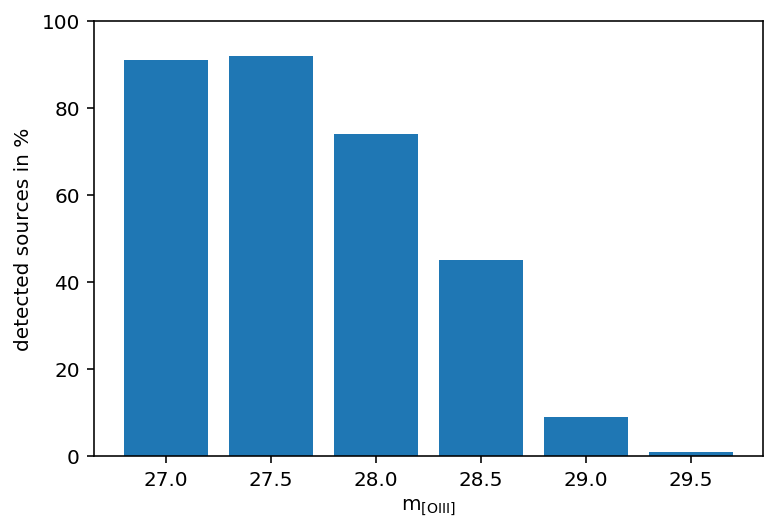

In [115]:
mock_sources = completeness_limit(
                   NGC628,
                   'OIII5006',
                   DAOStarFinder,
                   threshold=5,
                   iterations=10,
                   oversize_PSF=1.
                                 )

In [ ]:
mock_sources = completeness_limit(
                   NGC628,
                   'OIII5006',
                   DAOStarFinder,
                   threshold=8,
                   iterations=1,
                   oversize_PSF=1.
                                 )

## Flux measurement

In the previous step we detected potential PN candidates by their [OIII] emission. This means we know their position but lack exact flux measurments. In this section we measure the flux of the identified objects in different emission lines that are used in later steps. 

### Growth curve analysis

for the PSF we assume a 2D gaussian that is centered around the origin and has a variance of $\sigma_x^2 = \sigma_y^2 = \sigma^2$ and an amplitude of $A$
$$
f(x,y) = A \exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)
$$
we can rewrite this in polar coordinates as 
$$
f(r,\phi) = A \exp\left(-\frac{r^2}{2\sigma^2}\right)
$$
The light inside an aperture of radius $P(R)$ is given by the integral
$$
P(R) = \int_0^{2\pi} \int_0^R f(r,\phi) \mathrm{d} \phi r \mathrm{d} r = 2\pi \sigma^2 A \left(1-\exp \left(-\frac{R^2}{2\sigma^2}\right) \right) 
$$
We are interested in the ratio $p(R) = P(R) / P(\infty)$. If we use the relation between the standard deviation and the $\mathrm{FWHM}$ of a Gaussian $\sigma = \frac{\mathrm{FWHM}}{2\sqrt{2\ln2}}=$, we can write
$$
\begin{align}
p(R) = 1-\exp\left(- \frac{4 \ln 2 \cdot R^2}{\mathrm{fwhm}^2} \right)
\end{align}
$$

In [ ]:
def light_in_aperture(radius,fwhm):
    '''
    p(r) = 1 - e^(-4 ln2 r^2/fwhm^2)
    
    Given a circular aperture with the specified radius, this function
    calculates the fraction of light inside the aperture if the 
    underlying distribution is a 2D gaussian with the specified fwhm.     
    '''
    
    return 1-np.exp(- 4*np.log(2)*radius**2 / fwhm**2)

d = np.linspace(0.5,4)
p = light_in_aperture(d/2,1)
plt.plot(d,100*p)
plt.xlabel('diameter in fwhm')
plt.ylabel('light in aperture in %')
plt.grid()

the previous calculation is based on two assumptions:
 1. The PSF has the shape of a 2D Gaussian
 2. We know the $\mathrm{FWHM}$ of said PSF
 
to validate those assumptions, we measure the flux as a function of aperture radius for different sources to check if if the shape is a Gaussian and to measure the real value of the $\mathrm{FWHM}$.

In [ ]:
from pymuse.plot import single_cutout
from pymuse.photometry import growth_curve

In [ ]:
# we cannot sort a Table that has a SkyCoord object as a column
del sources['SkyCoord']

In [ ]:
# sort by brightness and select only sources from one pointing
sources.sort('peak',reverse=True)
PSF_fwhm = np.unique(sources['fwhm'])
sub = sources[(sources['fwhm']==PSF_fwhm[2])]

In [ ]:
# select one of the bright sources and take a look at it
i = 3
x,y = sub[i][['x','y']]
guess=sub[i]['fwhm']
single_cutout(NGC628,'whitelight',x,y)
sub[i]

In [ ]:
data = NGC628.whitelight

# this requires the next cell
fit,sig = growth_curve(data,x,y,guess=0.8*guess,plot=True)
print(f'reported={guess:.2f}, measured={fit[0]:.2f}, ratio={fit[0]/guess:.2f}')

### Aperture Photometry

we use the positions of the previously detected sources to measure the flux of different lines

https://photutils.readthedocs.io/en/stable/aperture.html

the values in the pixels are in units of $10^{-20} \ \mathrm{erg}  \ \mathrm{cm}^{-2} \ \mathrm{s}^{-1} / \mathrm{spaxel}$. For the [OIII] line, this flux is then converted to an apparent magnitude
$$
m_{[\mathrm{O\ III}]} = -2.5 \cdot \log F_{[\mathrm{O\ III}]} - 13.74
$$

where $F_{[\mathrm{O\ III}]}$ is given in $\mathrm{erg}  \ \mathrm{cm}^{-2} \ \mathrm{s}^{-1}$. Error propagation gives the error of the magnitude as

$$
\Delta m_{[\mathrm{O\ III}]} = \sqrt{\left(\frac{-2.5 \cdot \Delta F_{[\mathrm{O\ III}]}}{\ln 10 \cdot F_{[\mathrm{O\ III}]}}\right)^2 }
$$

We only correct for extinction in the milky way. therefor we use the extinction function from Cardelli, Clayton & Mathis (1989) with $A_V = 0.2$ and $R_V=3.1$. The extinction is calculated with the following package

https://extinction.readthedocs.io/en/latest/

(Note: the DAP products are already extinction corrected).

**Requires**
 * `extinction` a python package to account for the extinction in the Milky Way.
 * `measure_flux` from `pymuse.photometry`
 
**Returns**
 * `flux` a Table with the measured line fluxes.

In [23]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

from extinction import ccm89     # calculate extinction Cardelli et al. (1989)

from pymuse.photometry import measure_flux

In [103]:
#NGC628.lines.append('OIII5006_DAP')
flux = measure_flux(NGC628,aperture_size=3)

extinction = ccm89(wave=np.array([5007.]),a_v=0.2,r_v=3.1,unit='aa')[0]
flux['mOIII'] -= extinction

INFO:pymuse.photometry:measuring fluxes in NGC628 for 1749 sources
INFO:pymuse.photometry:measuring fluxes in [OIII5006] line map
INFO:pymuse.photometry:measuring fluxes in [HA6562] line map
INFO:pymuse.photometry:measuring fluxes in [NII6583] line map
INFO:pymuse.photometry:measuring fluxes in [SII6716] line map
INFO:pymuse.photometry:all flux measurements completed


#### Compare to Kreckel et al. 2017

In [44]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

17 PN match within 0.5"
the mean deviation is 0.372 dex


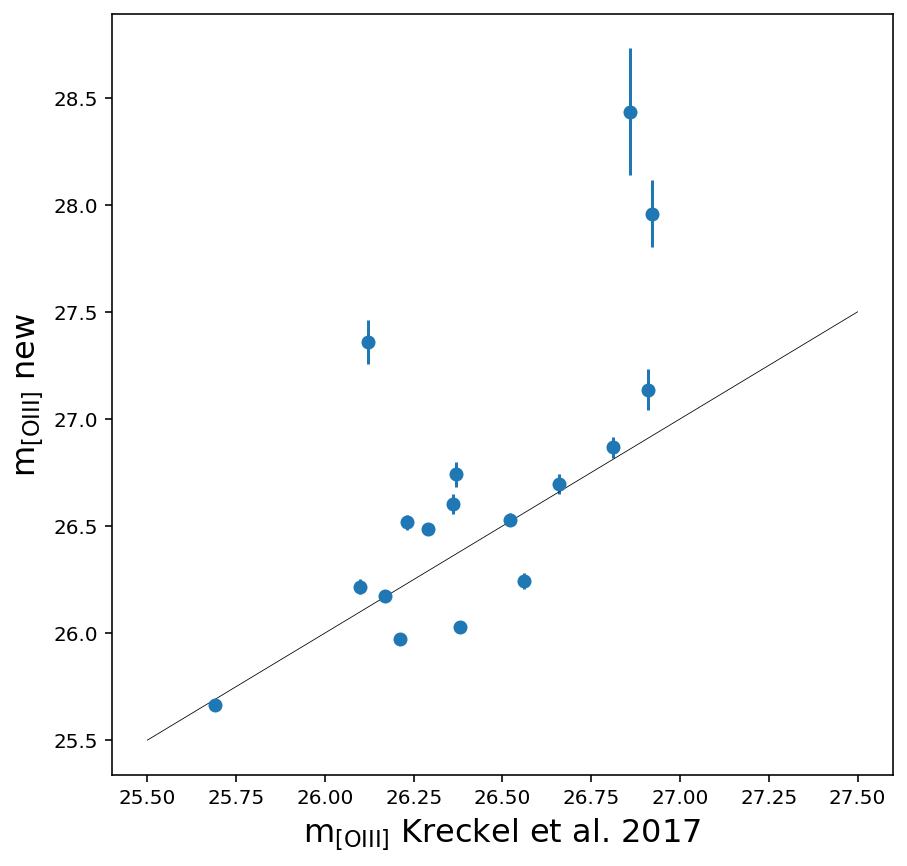

In [105]:
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],flux['SkyCoord'])

# for each object from Kreckel et al. 2017, we search for the nearest source
# and copy our measured quantities to compare the two
pn_bright['mOIII_measured']  = flux[ID]['mOIII']
pn_bright['dmOIII_measured'] = flux[ID]['dmOIII']
pn_bright['sep'] = angle

fig,ax = plt.subplots(figsize=(7,7))

# we only use sources when their position agrees within this tolerance
tolerance = '0.5"'

# calculate the difference in magnitude for those objects
dif = np.mean(np.abs(pn_bright[angle<Angle(tolerance)]['mOIII'] - pn_bright[angle<Angle(tolerance)]['mOIII_measured']))

print(f'{len(pn_bright[angle<Angle(tolerance)])} PN match within {tolerance}')
print(f'the mean deviation is {dif:.3f} dex')

ax.errorbar(pn_bright[angle<Angle(tolerance)]['mOIII'],
            pn_bright[angle<Angle(tolerance)]['mOIII_measured'],
            yerr=pn_bright[angle<Angle(tolerance)]['dmOIII_measured'],
            fmt='o')

ax.plot([25.5,27.5],[25.5,27.5],color='black',lw=0.4)
ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ Kreckel et al. 2017',fontsize=16)
ax.set_ylabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ new',fontsize=16)

plt.show()

## Emission line diagnostics

We built a catalgoue of possible planetary nebula and measuerd different emission lines. However this catalogue still contains objects that are similar to PN like HII regions or supernova remenants (SNR). In this next step we use emission line diagnostics to eliminate those contanimations. The distance modulus $\mu$ is defined as the difference between the apparent and the absolute magnitude. By definition of the absolute magnitude, this relates to the distance $d$ in parsec as 
$$
\begin{align}
\mu = m - M \\
d = 10^{1+\frac{\mu}{5}}
\end{align}
$$

 1. filter out HII regions
    $$
     4 > \log_{10} \frac{[\mathrm{OIII}]}{\mathrm{H}\alpha +[\mathrm{NII}]} > -0.37 M_{[\mathrm{OIII}]} - 1.16
    $$
 2. filter out SNR
    $$
     \mathrm{H}\alpha / [\mathrm{SII}] > 2.5
    $$
    
 3. estimate completness limit (for now I use 28) and remove fainter sources
    

In [110]:

def emission_line_diagnostics(table,distance_modulus,completeness_limit):
    '''Classify sources based on emission lines 
    
    criteria1:
    4 > log10 [OIII] / (Ha +[NII])
    
    criteria2:
    log10 [OIII] / (Ha +[NII]) > -0.37 M[OIII] - 1.16
    
    
    Parameters
    ----------
    table : Astropy Table
        Table with measured fluxes 
    
    completeness_limit : float
        Sources fainter than this magnitude are ignored
        
    distance_modulus : float 
       A first guess of the distance modulus (used for diagnostics)
       distance_modulus = m - M
    '''
    
        
    # make sure the input is of the correct type
    if not isinstance(table,Table):
        raise TypeError('wrong input')
    
    # next we check if all columns exist
    required = ['OIII5006','HA6562','NII6583','SII6716','mOIII']
    missing = set(required) - set(flux.columns)
    if missing:
        raise KeyError(f'input table is missing {", ".join(missing)}')
    del missing
       
    #
    # Preparation
                       
    # calculate the absolute magnitude based on a first estimate of the distance modulus 
    table['MOIII'] = table['mOIII'] - distance_modulus
    # make sure that the new column can save strings with 3 characters
    table['type'] = np.empty(len(table),dtype='U3')
    table['type'][:] = 'PN'
                       
    # if the flux is smaller than the error we set it to the error
    for line in ['OIII5006','HA6562','NII6583','SII6716']:
        table[table[line]<table[f'{line}_err']][line] = table[table[line]<table[f'{line}_err']][f'{line}_err']
                       
    logger.info(f'{len(table)} entries in initial catalogue')
             
    # remove rows with NaN values in some columns
    mask =  np.ones(len(table), dtype=bool)
    for col in required:
        mask &=  ~np.isnan(table[col])
    table = table[mask]
    logger.info(f'{len(mask[mask==False])} rows were removed because they contain NaN values')

    mask = table['mOIII']< completeness_limit
    table = table[mask]
    logger.info(f'{len(mask[mask==False])} objects below the completness limit removed')    
                       
    table['type'][np.where(4 < np.log10(table['OIII5006'] / (table['HA6562']+table['NII6583'])))] = ''
    table['type'][np.where(np.log10(table['OIII5006'] / (table['HA6562']+table['NII6583'])) < -0.37*table['MOIII'] - 1.16)] = 'HII'
    table['type'][np.where(table['HA6562'] / table['SII6716'] < 2.5)] = 'SNR'

    logger.info(f'{len(table[table["type"]=="HII"])} objects classified as HII')
    logger.info(f'{len(table[table["type"]==""])} objects classified as ...')
    logger.info(f'{len(table[table["type"]=="SNR"])} objects classified as SNR')
    logger.info(f'{len(table[table["type"]=="PN"])} possible planetary nebula found')
    
    return table
    
    
tbl = emission_line_diagnostics(flux,29.91,28.)


INFO:__main__:1749 entries in initial catalogue
INFO:__main__:818 rows were removed because they contain NaN values
INFO:__main__:583 objects below the completness limit removed
INFO:__main__:247 objects classified as HII
INFO:__main__:0 objects classified as ...
INFO:__main__:72 objects classified as SNR
INFO:__main__:29 possible planetary nebula found


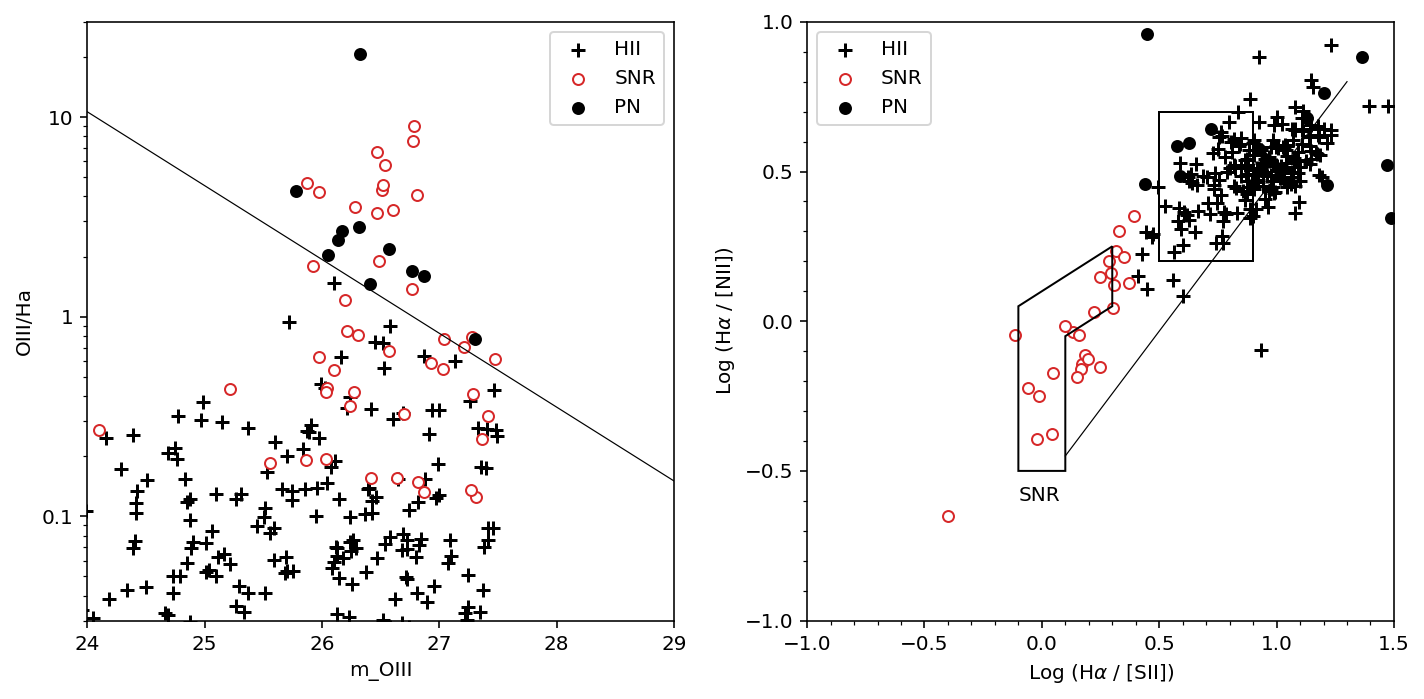

In [107]:
def plot_emission_line_ratio(table):
    
    
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    
    style = {'SNR':{"marker":'o',"s":30,"edgecolors":'tab:red',"facecolors":'white'},
             'HII':{"marker":'+',"s":50,"color":'black'},
             'PN':{"marker":'o',"s":30,"color":'black'}
            }

    # ------------------------------------------------
    # left plot [OIII]/Ha over mOIII
    # ------------------------------------------------
    mOIII = np.linspace(24,29)
    mu = 29.91
    OIII_Ha = 10**(-0.37*(mOIII-mu)-1.16)
    ax1.plot(mOIII,OIII_Ha,c='black',lw=0.6)
    

    for t in ['HII','SNR','PN']:
        tbl = table[table['type']==t]
        ax1.scatter(tbl['mOIII'],tbl['OIII5006']/(tbl['HA6562']+tbl['NII6583']),**style[t],label=t)
    ax1.legend()
    
    ax1.set(xlim=[24,29],
           ylim=[0.03,30],
           yscale='log',
           xlabel='m_OIII',
           ylabel='OIII/Ha')
    
    ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.16g}'.format(y)))

    # ------------------------------------------------
    # right plot Ha/[NII] over Ha/[SII]
    # ------------------------------------------------
    #mOIII = np.linspace(24,29)
    #mu = 29.91
    #OIII_Ha = 10**(-0.37*(mOIII-mu)-1.16)
    #ax1.plot(mOIII,OIII_Ha)
    
    for t in ['HII','SNR','PN']:
        tbl = table[table['type']==t]
        ax2.scatter(np.log10(tbl['HA6562']/tbl['SII6716']),
                    np.log10(tbl['HA6562']/tbl['NII6583']),**style[t],label=t)
    ax2.legend()
    
    vert_SNR = np.array([[-0.1,-0.5],[-0.1,0.05],[0.3,0.25],[0.3,0.05],[0.1,-0.05],[0.1,-0.5]])
    ax2.add_patch(mpl.patches.Polygon(vert_SNR,Fill=False,edgecolor='black'))
    vert_SNR = np.array([[0.5,0.2],[0.5,0.7],[0.9,0.7],[0.9,0.2]])
    ax2.add_patch(mpl.patches.Polygon(vert_SNR,Fill=False,edgecolor='black'))
    ax2.plot([0.1,1.3],[-0.45,0.8],c='black',lw=0.6)
    ax2.text(-0.1,-0.6,'SNR')
    
    ax2.set(xlim=[-1,1.5],
           ylim=[-1,1],
           #yscale='log',
           xlabel=r'Log (H$\alpha$ / [SII])',
           ylabel=r'Log (H$\alpha$ / [NII])')    
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))    

    plt.tight_layout()
    plt.show()
    
plot_emission_line_ratio(tbl)

### Compare classification to the results from Francesco Santoro

In [ ]:
from pymuse.detection import match_catalogues

In [29]:
with fits.open(basedir / 'data' / 'external' / 'FS_cat_v01.fits') as hdul:
    cat_FS = Table(hdul[1].data)

Search for PNe that were classified by Francescos in my catalogue

In [117]:
PNe_candidates = cat_FS[(cat_FS['gal_name']=='NGC628') & (cat_FS['PNe_candidate']==1)]
idx, sep = match_catalogues(PNe_candidates[['cen_x','cen_y']],tbl[['x','y']])

max_sep = 2
print(f'sep < {max_sep} px: {sum(sep<max_sep)/len(sep)*100:.2f} %')
tbl[(idx)]

sep < 2 px: 80.00 %


id,x,y,fwhm,OIII5006,OIII5006_err,HA6562,HA6562_err,NII6583,NII6583_err,SII6716,SII6716_err,SkyCoord,mOIII,dmOIII,MOIII,type
,,,,,,,,,,,,"deg,deg",,,,
int32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,str3
1203,515.8400223989944,230.51828383480031,3.71,8798.7247,161.48597,2147.4258,124.94227,1139.8278,102.76278,26.639574,89.977459,"24.18502150176532,15.754387463799295",26.174906,0.019926884,-3.7350941,PN
734,512.7300932779223,404.21878309112424,3.56,4622.4033,181.36172,2648.326,143.39762,251.23616,105.07537,461.64496,100.72094,"24.185200734852017,15.764037493818082",26.873786,0.042599266,-3.0362144,PN
775,404.570194862005,474.02346231517816,3.56,6439.9185,173.41041,1473.5951,141.52946,27.083586,108.12712,-84.070433,101.70915,"24.19144445698025,15.767915612149196",26.513754,0.029236079,-3.3962457,SNR
474,244.0446228524939,519.9709363914146,3.38,8463.418,233.73131,16216.347,281.25284,7967.3535,174.9954,4150.4698,162.94962,"24.200711370291085,15.770468041813396",26.217091,0.029984405,-3.6929093,HII
1072,893.1702808237892,615.8227833198097,3.68,6104.6594,136.514,2386.5394,127.15418,412.47709,101.09274,149.83062,92.853306,"24.163237549538902,15.775791569844612",26.571802,0.02427952,-3.3381984,PN
1081,900.4393695746985,634.7573719841381,3.68,6410.313,136.88234,1694.7859,126.86034,-297.71214,100.12409,-600.43935,94.039009,"24.16281775739706,15.77684343732281",26.518757,0.023184221,-3.3912429,SNR
40,836.4752091758673,764.6123246533627,2.96,12663.02,164.54604,2447.5367,140.10024,511.4755,117.85986,182.43227,108.16984,"24.166509553574897,15.784058047549488",25.779612,0.014108293,-4.130388,PN
1438,585.4221415698565,844.7372108531783,3.82,2009.5344,312.37497,-2540.1542,190.65868,-3332.4169,168.55595,-2107.1256,158.86583,"24.18100323270008,15.788510583297091",27.778217,0.16877383,-2.1317834,SNR


Search for HII regions that were classified by me in Francescos catalogue

In [109]:
HII_candidates = tbl[tbl['type'] == 'HII']
catalogue = cat_FS[(~np.isnan(cat_FS['cen_x'])) & (~np.isnan(cat_FS['cen_y'])) & (cat_FS['gal_name']=='NGC628')]
idx, sep = match_catalogues(HII_candidates[['x','y']],catalogue[['cen_x','cen_y']])

print(f'sep < 1 px: {sum(sep<1)/len(sep)*100:.2f} %')
catalogue[idx]

sep < 1 px: 31.02 %


gal_name,region_ID,type_ID,cen_x,cen_y,cen_ra,cen_dec,region_size_pixels,HB4861_FLUX,OIII5006_FLUX,HA6562_FLUX,NII6583_FLUX,SII6716_FLUX,SII6730_FLUX,SIII9068_FLUX,OI6300_FLUX,NII5754_FLUX,HB4861_FLUX_ERR,OIII5006_FLUX_ERR,HA6562_FLUX_ERR,NII6583_FLUX_ERR,SII6716_FLUX_ERR,SII6730_FLUX_ERR,SIII9068_FLUX_ERR,OI6300_FLUX_ERR,NII5754_FLUX_ERR,HB4861_SIGMA,OIII5006_SIGMA,HA6562_SIGMA,NII6583_SIGMA,SII6716_SIGMA,SII6730_SIGMA,SIII9068_SIGMA,OI6300_SIGMA,NII5754_SIGMA,stmass,Data_issue,BPT_outlier,SNR_candidate,PNe_candidate,HII_region_class
str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
NGC628,1904.0,1.0,807.0919734399712,691.8162673866256,24.168206377301647,15.780014007099203,42.0,13898.220939792067,22179.174388030202,54860.354219685105,21865.481709200965,7860.789080240951,5524.043485300055,3446.8403060018327,1882.3019728544339,329.34548053079203,149.30161362008644,168.16432775689668,203.3809991626389,133.1093585501344,105.14940839697138,102.42568884260602,126.75738150519547,110.84804307463995,116.73269792268118,14.164156479306866,10.755744350100231,14.16415647930685,20.179578599773087,20.179578599773087,20.179578599773087,10.755744350100217,20.179578599773073,20.179578599773073,341.7103105404793,0,1,0,0,0
NGC628,363.0,1.0,760.523793623436,686.6095520485351,24.170894846446547,15.77972501067408,134.0,161460.244420699,10102.155583502346,621297.916402833,142350.65939052132,49996.271075977056,33655.919377285565,16566.636081806835,3947.95910699525,718.8278066249193,404.94412418715757,223.09579323211275,618.5851085072849,290.2894549760248,220.00691450706057,203.7833693061603,255.64326899776455,191.7257831531854,215.1990192663616,18.28176249090659,15.314110888719425,18.281762490906566,20.47988262139271,20.479882621392704,20.479882621392704,15.314110888719437,20.479882621392704,20.479882621392704,338.26816119256847,0,0,0,0,1
NGC628,2182.0,2.0,804.1968154561525,724.2050355834613,24.168373315988305,15.781813400401214,29.0,2336.2214827355356,2934.084767862217,9582.494143710388,6394.594610301521,2444.559989871721,1645.143388439672,363.1486101447261,749.4831380370165,365.71644249229837,112.87325487186803,112.45439531951682,114.48263506233926,94.83968096570018,84.24865130504126,84.24233072570881,108.20979965362758,88.84543612417151,96.68743118155817,22.570887305901085,20.751493411634762,22.5708873059011,23.395134580417633,23.395134580417633,23.395134580417604,20.751493411634776,23.395134580417633,23.395134580417604,300.9226598466344,0,1,0,0,0
NGC628,143.0,1.0,753.8865657076118,819.0762773067587,24.171277298935056,15.787084307819002,116.0,100264.58625797555,11562.315505723316,444284.66495335306,118760.27560260452,42233.735855402614,29940.589476639452,16125.576807498537,3860.9663238046983,611.3644959426682,357.3915179035086,218.5441558786183,510.492464196615,267.12091159694427,205.70850029800638,193.5437339011309,239.65823775794192,186.53880532410358,206.86685181275007,23.29913632840191,17.61149234658291,23.299136328401907,25.54062760890115,25.54062760890114,25.54062760890115,17.611492346582917,25.54062760890115,25.54062760890115,350.3254644357622,0,0,0,0,1
NGC628,1000.0,1.0,771.6805972183615,828.26675363613,24.170249938302803,15.787594793998386,41.0,7073.379136726285,6851.767702279054,23188.453680591123,15441.509832251451,6954.661169017006,4850.696719742446,869.3789235390876,1476.519356585721,426.08002859042256,143.55637970735248,140.8652025762401,146.55969448991792,122.91808010679014,103.9083135481756,101.05080312575774,119.36480063099353,111.08758016809588,118.1888492579784,27.768993429722418,1.0,27.768993429722414,27.89542937924963,27.89542937924963,27.89542937924963,0.9999999999998863,27.89542937924963,27.895429379249645,282.9412997184915,0,1,0,0,0
NGC628,278.0,1.0,897.956252243

## Planetary nebula luminosity function



$$ 
\begin{align}
N(M) \propto e^{0.307 M} \left( 1- e^{3(M^*-M)} \right)
\end{align}
$$

### With least square  fitting

 - to use a least square approach we need to bin the data. 
 + easier to implement

In [ ]:
from scipy.optimize import minimize, curve_fit
from inspect import signature

In [ ]:
def pnlf(m,mu,N0):
    '''planetary nebula luminosity function
    
    Parameters
    ----------
        
    m : ndarray
        apparent magnitudes of the PNs
        
    mu : float
        distance modulus
    '''
    
    Mmax = -4.47
    delta = 2.5
    norm = np.exp(0.307*Mmax - 2.693*delta)*(0.371333 - 3.62866*np.exp(2.693*delta) + 3.25733 * np.exp(3*delta))
    
    return N0*np.exp(0.307*(m-mu)) * (1-np.exp(3*(Mmax-m+mu)))

def fit_pnlf(table):
    
    #table = table[table['type']=='PN']
    
    binsize = 0.4
    guess = np.array([25,10])
    
    mlow = np.floor(np.min(table))
    mhigh = np.ceil(np.max(table))
    hist,bins  = np.histogram(table,np.arange(mlow,mhigh,binsize))
    
    fit,sig = curve_fit(pnlf, bins[1:]+binsize/2,hist , guess)
    mu, N0 = fit
    print(f'mu={mu:.3f}, N0={N0:.2f}')
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
    
    ax1.scatter(bins[:-1]+binsize/2,hist)
    ax1.plot(bins[:-1]+binsize/2,pnlf(bins[:-1]+0.1,mu=mu,N0=N0),c='tab:orange',ls='--')
    ax1.set_yscale('log')
    ax1.set_xlim([25,28])
    ax1.set_ylim([0.8,1.1*np.max(hist)])
    ax1.set_xlabel('$m_{[\mathrm{OIII}]}$')
    ax1.set_ylabel('$N$')
    
    ax2.plot(bins[1:]+binsize/2,np.cumsum(hist))
    ax2.plot(bins[1:]+binsize/2,np.cumsum(pnlf(bins[:-1]+binsize/2,mu=mu,N0=N0)),ls='--')
    ax2.set_xlim([mlow,mhigh])
    ax2.set_ylim([0,len(table)])
    ax2.set_xlabel('$m_{[\mathrm{OIII}]}$')
    ax2.set_ylabel('Cumulative N')
    
fit_pnlf(tbl[tbl['type']=='PN']['mOIII'])

### With maximum liklihood

Maximum liklihood estimator

In [ ]:
class MaximumLikelihood:
    '''
    
    Parameters
    ----------
    func : function
        PDF of the form `func(data,params)`. `func` must accept a
        ndarray for `data` and can have any number of additional
        parameters.
        
    data : ndarray
        Measured data that are feed into `func`.
    '''
    
    def __init__(self,func,data):
        
        self.data = data
        if len(signature(func).parameters)<2:
            raise ValueError(f'`func` must accept at least two arguments')
        self.func = func

    def loglik(self,params):
        '''calculate the log liklihood of the given parameters
        
        This function takes the previously specified PDF and calculates
        the sum of the logarithmic probabilities.
        '''
        
        return np.sum(np.log(self.func(self.data,*params)))
    
    def fit(self,guess):
        '''use scipy minimize to find the best parameters'''
        
        self.result = minimize(self.loglik,guess,method ='Nelder-Mead')
        #for name,var in zip(list(signature(self.func).parameters)[1:],self.result.x):
        #    print(f'{name}={var:.3g}')
        return self.result.x
    
    def __call__(self,guess):
        return self.fit(guess)
        
fitter = MaximumLikelihood(pnlf,tbl[tbl['type']=='PN']['mOIII'])
fitter([25,20])


### Distance in parsec

$$
d = 10^{\frac{\mu}{5}+1} = 10 \cdot \exp\left( \ln 10 \frac{\mu}{5} \right) \\
\delta d = \frac{\ln 10}{5} 10 \exp\left( \ln 10 \frac{\mu}{5} \right) \delta \mu = 0.2 \ln 10 d \delta \mu
$$